In [54]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [55]:
from pathlib import Path

DATA_DIR = Path.cwd().parent.parent / "data"

DATA_DIR

PosixPath('/workspaces/mnist/data')

In [56]:
import torch

generator = torch.Generator().manual_seed(42)

# Splits

In [57]:

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_ds = MNIST(
    root=DATA_DIR / "train",
    train=True,
    download=True,
    transform=ToTensor(),
)

train_ds

Dataset MNIST
    Number of datapoints: 60000
    Root location: /workspaces/mnist/data/train
    Split: Train
    StandardTransform
Transform: ToTensor()

In [58]:
import torch
from torch.utils.data import random_split

DEV_SIZE = 10_000

train_ds, dev_ds = random_split(
    train_ds,
    [len(train_ds) - DEV_SIZE, DEV_SIZE],
    generator=torch.Generator().manual_seed(42),
)

len(train_ds), len(dev_ds)

(50000, 10000)

In [59]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_ds, batch_size=8, shuffle=False)

x, y = next(iter(dataloader))

x.shape, y.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

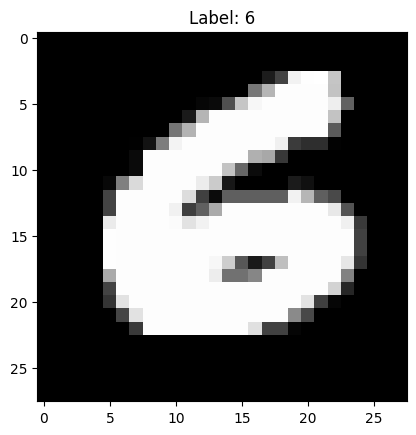

In [60]:
import matplotlib.pyplot as plt

x = x.to("cpu")

plt.title(f"Label: {y[0]}")
plt.imshow(x.squeeze()[0], cmap="gray")

plt.show()

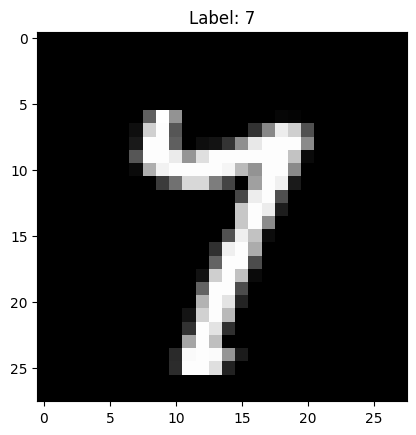

In [61]:
x = x.to("cpu")

plt.title(f"Label: {y[1]}")
plt.imshow(x.squeeze()[1], cmap="gray")

plt.show()

# Definition

TODO
- batch norm
- hyperparameter tuning
- quantization

In [70]:
X_train = train_ds.dataset.data.float()

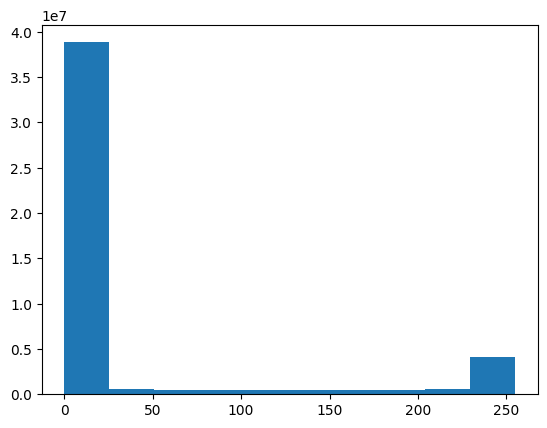

In [71]:
from matplotlib import pyplot as plt

plt.hist(X_train.flatten())

plt.show()

In [115]:
min = X_train.min().item()
max = X_train.max().item()

min, max

(0.0, 255.0)

In [107]:
mean = X_train.mean().item()

std = X_train.std().item()

mean, std

(33.31842041015625, 78.56748962402344)

with relu activations, conventional normalization (e.g., converting to standard deviations) with a 0-skewed input dataset, gradients will likely vanish. trying min-max scaling instead. since the min is 0, this will end up just dividing each input by 255

In [116]:
import torch.nn as nn

class Scale(nn.Module):
    min: float
    max: float

    def __init__(self, min: float, max: float):
        super().__init__()
        self.min = min
        self.max = max

    def forward(self, x):
        return (x - self.min) / (self.max - self.min)

In [117]:
import torch
import torch.nn as nn

@torch.compile
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = Scale(min, max)
        self.flatten = nn.Flatten(1, -1) # (B, 28, 28) -> (B, 28*28)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.scale(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [118]:
model = MLP()

model

MLP(
  (scale): Scale()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [119]:
logits = model(x)

logits.shape

torch.Size([8, 10])

In [120]:
logits.argmax(1)

tensor([9, 9, 9, 9, 9, 9, 9, 9])

# Training

In [ ]:
import wandb

run = wandb.init(project="mnist", config={
    "architecture": "mlp",
    "epochs": 8,
    "batch_size": 64,
    "learning_rate": 1e-3,
})

In [122]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import TypedDict

class LoopMetrics(TypedDict):
    accuracy: float
    loss: float

def train_loop(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer) -> LoopMetrics:
    model = model.to(device).train()
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.squeeze()

        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()
        run.log({"train_batch_loss": loss.item()})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct += (
            (pred.argmax(1) == y)
            .type(torch.float)
            .sum()
            .item()
        )

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    accuracy = correct / size
    train_loss /= size

    print(f"Train Error: \n Accuracy: {100 * accuracy:>0.1f}%, Avg loss: {train_loss:>8f} \n")

    return {
        "accuracy": accuracy,
        "loss": train_loss,
    }

@torch.no_grad
def test_loop(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module) -> LoopMetrics:
    model = model.to(device).eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        X = X.squeeze()

        pred = model(X)
        loss = loss_fn(pred, y)
    
        test_loss += loss.item()
    
        correct += (
            (pred.argmax(1) == y)
            .type(torch.float)
            .sum()
            .item()
        )

    test_loss /= size
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {100 * accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {
        "accuracy": accuracy,
        "loss": test_loss,
    }

In [123]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, batch_size=run.config.batch_size, shuffle=True, generator=generator)
dev_dataloader = DataLoader(dev_ds, batch_size=run.config.batch_size, shuffle=False)

model = MLP()

run.watch(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=run.config.learning_rate)

for t in range(run.config.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_metrics = train_loop(model, train_dataloader, loss_fn, optimizer)
    test_metrics = test_loop(model, dev_dataloader, loss_fn)
    run.log({
        "train_epoch_accuracy": train_metrics["accuracy"],
        "train_epoch_loss": train_metrics["loss"],
        "test_epoch_accuracy": test_metrics["accuracy"],
        "test_epoch_loss": test_metrics["loss"],
    })

run.finish()

Epoch 1
-------------------------------
loss: 2.306116  [    0/50000]
loss: 2.305594  [ 6400/50000]
loss: 2.183962  [12800/50000]
loss: 1.914635  [19200/50000]
loss: 1.567696  [25600/50000]
loss: 1.332288  [32000/50000]
loss: 1.262606  [38400/50000]
loss: 1.254954  [44800/50000]
Train Error: 
 Accuracy: 41.0%, Avg loss: 0.026136 

Test Error: 
 Accuracy: 61.9%, Avg loss: 0.017246 

Epoch 2
-------------------------------
loss: 1.074928  [    0/50000]
loss: 1.153026  [ 6400/50000]
loss: 0.803108  [12800/50000]
loss: 0.852561  [19200/50000]
loss: 0.869743  [25600/50000]
loss: 0.801796  [32000/50000]
loss: 1.233355  [38400/50000]
loss: 0.942189  [44800/50000]
Train Error: 
 Accuracy: 69.9%, Avg loss: 0.014013 

Test Error: 
 Accuracy: 74.2%, Avg loss: 0.012177 

Epoch 3
-------------------------------
loss: 0.859019  [    0/50000]
loss: 0.904707  [ 6400/50000]
loss: 0.613518  [12800/50000]
loss: 0.782289  [19200/50000]
loss: 0.645170  [25600/50000]
loss: 0.654190  [32000/50000]
loss: 0.52

test_epoch_accuracy,▁▅▆▇█
test_epoch_loss,█▄▃▂▁
train_batch_loss,█▇▅▅▅▅▅▃▅▃▄▃▃▂▃▃▂▃▄▃▃▂▂▃▂▁▁▂▂▂▂▃▂▁▃▁▂▂▂▁
train_epoch_accuracy,▁▆▇██
train_epoch_loss,█▃▂▁▁
test_epoch_accuracy,0.8453
test_epoch_loss,0.00839
train_batch_loss,0.3317
train_epoch_accuracy,0.83672
train_epoch_loss,0.00869
